#Описание работы
В данной работе я написал парсер для сбора данных с объявлений с сайта объявлений о продаже товаров и услуг, а именно следующих данных: изображений (первое изображение в объявлении), текстов объявлений и цен указанных в объявлениях. Затем я построил несколько моделей для классификации объявлений по классам-категориям объявлений. Некоторые модели обучались только на изображениях, некоторые на текстовых данных, в конце я объединил фичи модели обученной на текстах объявлений и фичи модели обученной на изображениях сначала с помощью другой нейросети, затем с помощью моделей из классического обучения (логистическая регрессия, knn). В итоге лучшей моделью оказалась логистическая регрессия обученная на фичах из BERT-модели для текстов и EfficientNet, итоговое значение f1-метрик (взвешанной, микро и макро) для данной модели оказалось выше 0.99

In [ ]:
!pip install pytorch-lightning transformers datasets evaluate accelerate wandb

In [ ]:
import gdown

import os
from pathlib import Path
from collections import Counter
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as tfs
from torchvision import models
import torchmetrics
from transformers import BertTokenizer

import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
import wandb

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import sklearn.metrics as metrics
import accelerate

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

from google.colab import drive
drive.mount('/content/drive')

nltk.download('punkt')
nltk.download('stopwords')
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Загрузка данных


In [ ]:
!unzip /content/drive/MyDrive/...zip -d ...imgdata
!unzip /content/drive/MyDrive/...zip -d descrdata
!cp "/content/drive/MyDrive/...pth" "/content/"
!cp "/content/drive/MyDrive/...pth" "/content/"

In [ ]:
image_file_dir = Path('/content/...imgdata')
image_file_list = list(image_file_dir.rglob('*.jpg'))
csv_file_dir = Path('/content/descrdata')
csv_file_list = list(csv_file_dir.rglob('*.csv'))

# Подготовка данных

Сначала я подготовил датасет для классификации изображений, в качестве названия классов использовались названия папок

In [ ]:
class MarketDataset(Dataset):
    def __init__(self, files, transform, class_dict, train = True, seed = 42):
        self.files = np.array(files)
        self.transform = transform
        self.class_dict = class_dict

        np.random.seed(seed)
        permutation = np.random.permutation(len(self.files))

        # Разбиение на тренировочную/тестовую/валидационную выборки
        if train == 'train':
            self.files = self.files[
                permutation[: int(len(self.files) * 0.8)]
            ].tolist()
        elif train == 'test':
            self.files = self.files[
                permutation[int(len(self.files) * 0.8) : int(len(self.files) * 0.9)]
            ].tolist()
        else:
            self.files = self.files[
                permutation[int(len(self.files) * 0.9) :]
            ].tolist()


    def __len__(self):
          return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]

        image = np.array(Image.open(fname).convert('RGB'))
        # Применение аугментации
        image = self.transform(image = image)['image'].to(device)

        label = fname.parent.name
        # Кодирование класса
        label = self.class_dict[label]

        return image, label

    def get_all_labels(self):
        return [class_dict[f.parent.name] for f in self.files]

mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

# Аугментация
train_transform = A.Compose(
    [
        A.Resize(232, 232),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ]
)

test_transform = A.Compose(
    [
        A.Resize(232, 232),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ]
)

# Словари меток и индексов
class_dict = {name: label for label, name in enumerate([i for i in os.listdir(image_file_dir) if not('.' in i)])}
inv_class_dict = {v: k for k, v in class_dict.items()}

train_ds = MarketDataset(image_file_list, transform=train_transform, class_dict = class_dict, train='train')
test_ds = MarketDataset(image_file_list, transform=test_transform, class_dict = class_dict, train='test')
val_ds = MarketDataset(image_file_list, transform=test_transform, class_dict = class_dict, train='val')

# Исследовательский анализ

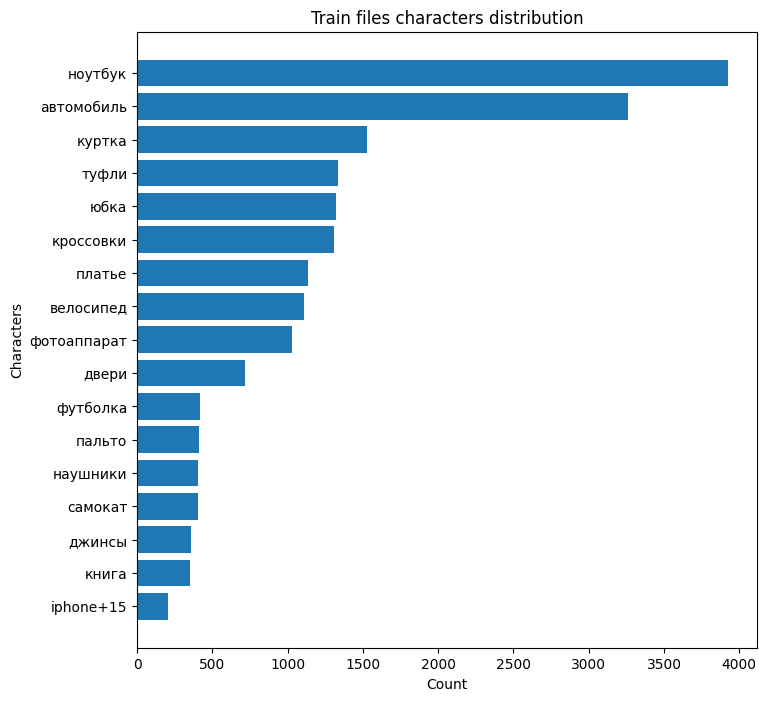

In [ ]:
val_counts = pd.Series(
    {label: len(os.listdir(os.path.join(image_file_dir, label))) for label in class_dict}
    ).sort_values(ascending = True)

plt.figure(figsize=(8,8))
plt.barh(val_counts.keys(), val_counts.values)
plt.title('Train files characters distribution')
plt.xlabel('Count')
plt.ylabel('Characters')
plt.show()

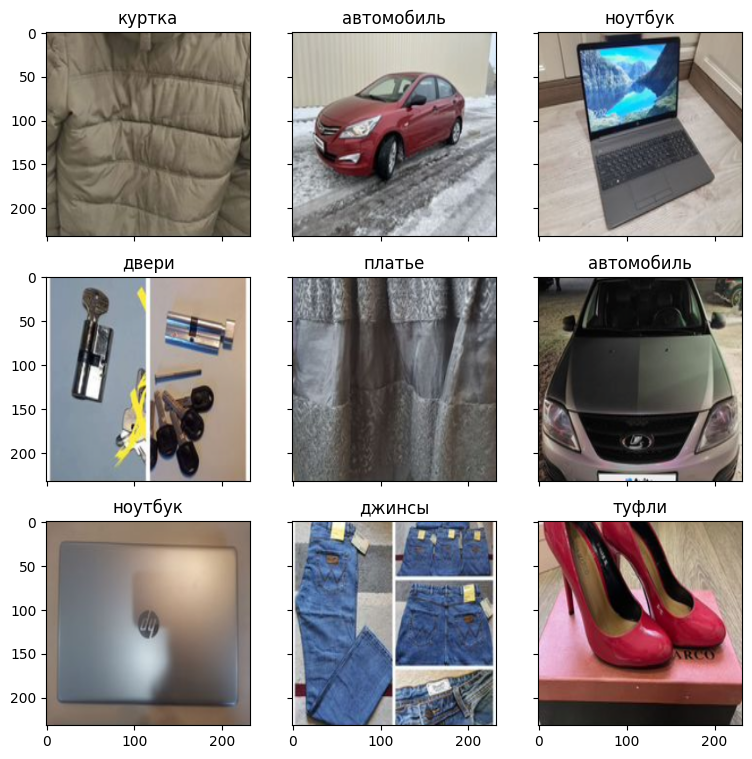

In [ ]:
mean = torch.tensor((0.485, 0.456, 0.406), device = device)
std = torch.tensor((0.229, 0.224, 0.225), device = device)
fig, ax = plt.subplots(figsize=(9,9), sharey=True, sharex=True,
                       nrows=3, ncols=3)

for figx in ax.ravel():
    random_character = np.array(np.random.uniform(len(train_ds)), dtype='int').item()
    img, label = train_ds[random_character]
    img = img.permute(1,2,0)
    img = img * std + mean
    img = img.cpu().numpy()
    img = np.clip(img, 0, 1)
    figx.set_title(inv_class_dict[label])
    figx.imshow(img)

# Pytorch

Классы несбалансированы, поэтому придется использовать взвешенный сэмплер

In [ ]:
# Подсчет весов для классов
cnt = Counter([i.parent.name for i in train_ds.files])
cnt = {class_dict[k]: 1/v for k, v in cnt.items()}
sample_weights = np.array([cnt[i] for i in train_ds.get_all_labels()])
batch_s = 32

train_sampler = WeightedRandomSampler(sample_weights, num_samples=len(train_ds), replacement=True)

train_dataloader = DataLoader(train_ds, batch_size = batch_s, sampler=train_sampler)
test_dataloader = DataLoader(test_ds, batch_size = batch_s)
val_dataloader = DataLoader(val_ds, batch_size = batch_s)

## Инициализация моделей
Я использовал простую самописную модель с последовательными свертками, затем пару ResNet и EfficientNet

In [ ]:
class SimpleCNN(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=2400, out_features=4800),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=4800, out_features=4800),
            nn.ReLU(),
        )
        self.fc3 = nn.Sequential(
            nn.Linear(in_features=4800, out_features=n_classes)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

simple_model = SimpleCNN(len(class_dict)).to(device)

resnet50_model = models.resnet50(pretrained=True)
num_features = resnet50_model.fc.in_features
resnet50_model.fc = nn.Linear(num_features, len(class_dict))
resnet50_model = resnet50_model.to(device)

resnet50x_model = models.resnext50_32x4d(pretrained=True)
num_features = resnet50x_model.fc.in_features
resnet50x_model.fc = nn.Linear(num_features, len(class_dict))
resneet50x_model = resnet50x_model.to(device)

efficientnet_model = models.efficientnet_v2_s(pretrained=True)
num_features = efficientnet_model.classifier[1].in_features
efficientnet_model.classifier[1] = nn.Linear(num_features, len(class_dict))
efficientnet_model = efficientnet_model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 41.3MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed 

## Обучение
Для обучения моделей я использовал библиотеку py-lightning, в качестве функции потерь использовал кросс-энтропию. Из-за того, что датасет несбалансирован в качестве метрик используется F1 трех видов - взвешенная, микро и макро.

In [ ]:
class LightningModule(pl.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.loss_f = nn.CrossEntropyLoss()
        self.validation_step_outputs = []
        self.validation_step_targets = []

    def forward(self, x):
        result = self.model(x)

        return result

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        images, target = train_batch
        pred = self.forward(images)

        out = self.loss_f(pred, target)

        self.log("train_loss", out)

        return out

    def validation_step(self, val_batch, batch_idx):
        images, target = val_batch
        pred = self.forward(images)

        out = self.loss_f(pred, target)

        preds = nn.functional.softmax(pred, dim=-1).argmax(-1)
        acc = torchmetrics.functional.accuracy(preds.long(),
                                               target.long(),
                                               task = 'multiclass',
                                               num_classes = len(class_dict))

        self.log("val_loss", out)
        self.log("accuracy", acc)

        self.validation_step_outputs.extend(preds.tolist())
        self.validation_step_targets.extend(target.tolist())

    def on_validation_epoch_end(self):
        val_all_outputs = self.validation_step_outputs
        val_all_targets = self.validation_step_targets

        f1_macro_val = metrics.f1_score(val_all_targets, val_all_outputs, average = 'macro')
        f1_micro_val = metrics.f1_score(val_all_targets, val_all_outputs, average = 'micro')
        acc = metrics.accuracy_score(val_all_targets, val_all_outputs)

        self.log("f1_macro_val", f1_macro_val)
        self.log("f1_micro_val", f1_micro_val)
        self.log("acc", acc)

        self.validation_step_outputs.clear()
        self.validation_step_targets.clear()

In [ ]:
module = LightningModule(simple_model, learning_rate=5e-5).to(device)

wandb_logger = WandbLogger(name = 'simplecnn_model', project="MarketData")

trainer = pl.Trainer(max_epochs = 5,
                    accelerator = 'gpu',
                    logger = wandb_logger)
trainer.fit(module, train_dataloader, test_dataloader)

wandb.finish()

In [ ]:
module = LightningModule(resnet50_model, learning_rate=5e-5).to(device)

wandb_logger = WandbLogger(name = 'resnet50', project="MarketData")

trainer = pl.Trainer(max_epochs = 5,
                    accelerator = 'gpu',
                    logger = wandb_logger)
trainer.fit(module, train_dataloader, test_dataloader)

wandb.finish()

In [ ]:
module = LightningModule(resnet50x_model, learning_rate=5e-5).to(device)

wandb_logger = WandbLogger(name = 'resnet50X', project="MarketData")

trainer = pl.Trainer(max_epochs = 5,
                    accelerator = 'gpu',
                    logger = wandb_logger)
trainer.fit(module, train_dataloader, test_dataloader)

wandb.finish()

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint

module = LightningModule(efficientnet_model, learning_rate=5e-5).to(device)

checkpoint_callback = ModelCheckpoint(
    dirpath=os.getcwd(),
    save_top_k=1,
    verbose=True,
    monitor='acc',
    mode='max'
)

wandb_logger = WandbLogger(name = 'efficient_net', project="MarketData")

trainer = pl.Trainer(max_epochs = 10,
                    accelerator = 'gpu',
                    logger = wandb_logger,
                    callbacks=[checkpoint_callback])
trainer.fit(module, train_dataloader, test_dataloader)

wandb.finish()

In [ ]:
def predict(model, test_dataloader):

    logits = []

    with torch.no_grad():
        for data, _ in tqdm(test_dataloader):
            data = data.to(device)
            model.eval()
            outputs = model(data)
            logits.append(outputs)

    return logits


model_dict = {'efficient_net': efficientnet_model,
              'simplecnn_model': simple_model,
              'resnet50': resnet50_model,
              'resnet50X':resnet50x_model}

model_res_dict = {}

for model in model_dict:
    cur_model = model_dict[model]
    predictions = predict(cur_model.to(device), val_dataloader)
    preds = nn.functional.softmax(torch.cat(predictions), dim=-1).argmax(-1).cpu().numpy()
    p = []
    for _, label in val_dataloader:
      p.extend(label.numpy())

    model_res_dict[model] = [metrics.f1_score(p, preds, average = 'macro'),
    metrics.f1_score(p, preds, average = 'micro'),
    metrics.accuracy_score(p, preds)]

In [ ]:
pd.DataFrame(model_res_dict).T.rename(columns = {0: 'f1_macro', 1: 'f1_micro', 2: 'accuracy'})

,f1_macro,f1_micro,accuracy
efficient_net,0.915080,0.941207,0.941207
simplecnn_model,0.418700,0.540583,0.540583
resnet50,0.878788,0.916233,0.916233
resnet50X,0.892389,0.921956,0.921956


Лучшей моделью оказался EfficientNet, процесс обучения я отслеживал с помощью wandb

https://api.wandb.ai/links/glebshevtsov24/ryw5fzv6

<iframe src="https://wandb.ai/glebshevtsov24/MarketData/reports/Market-Report--Vmlldzo2NDM1Nzk5" style="border:none;height:1024px;width:100%">

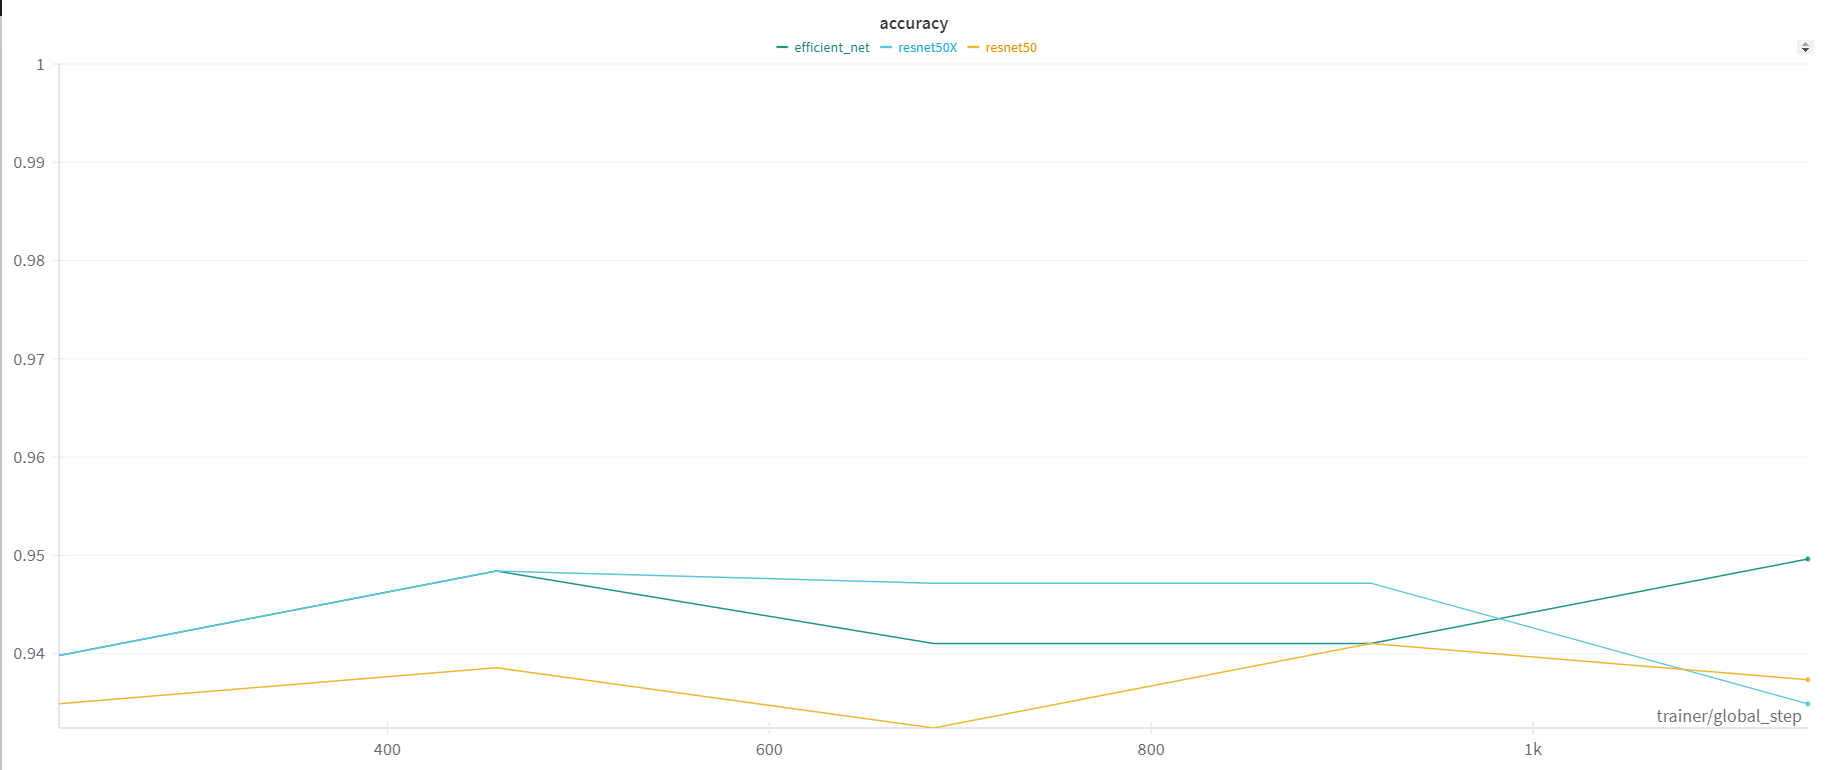

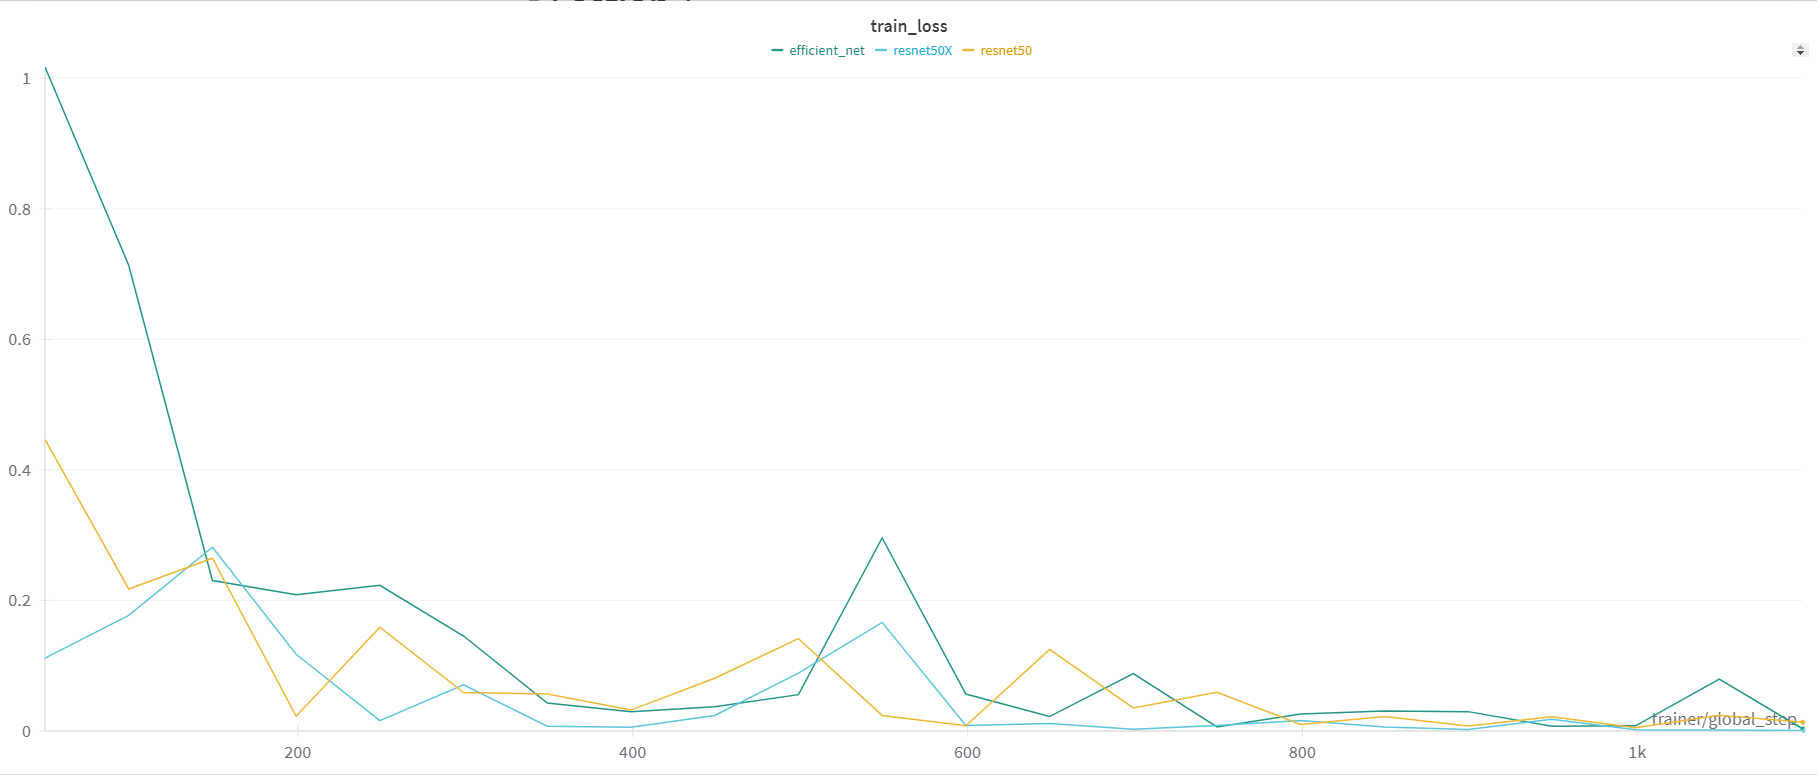

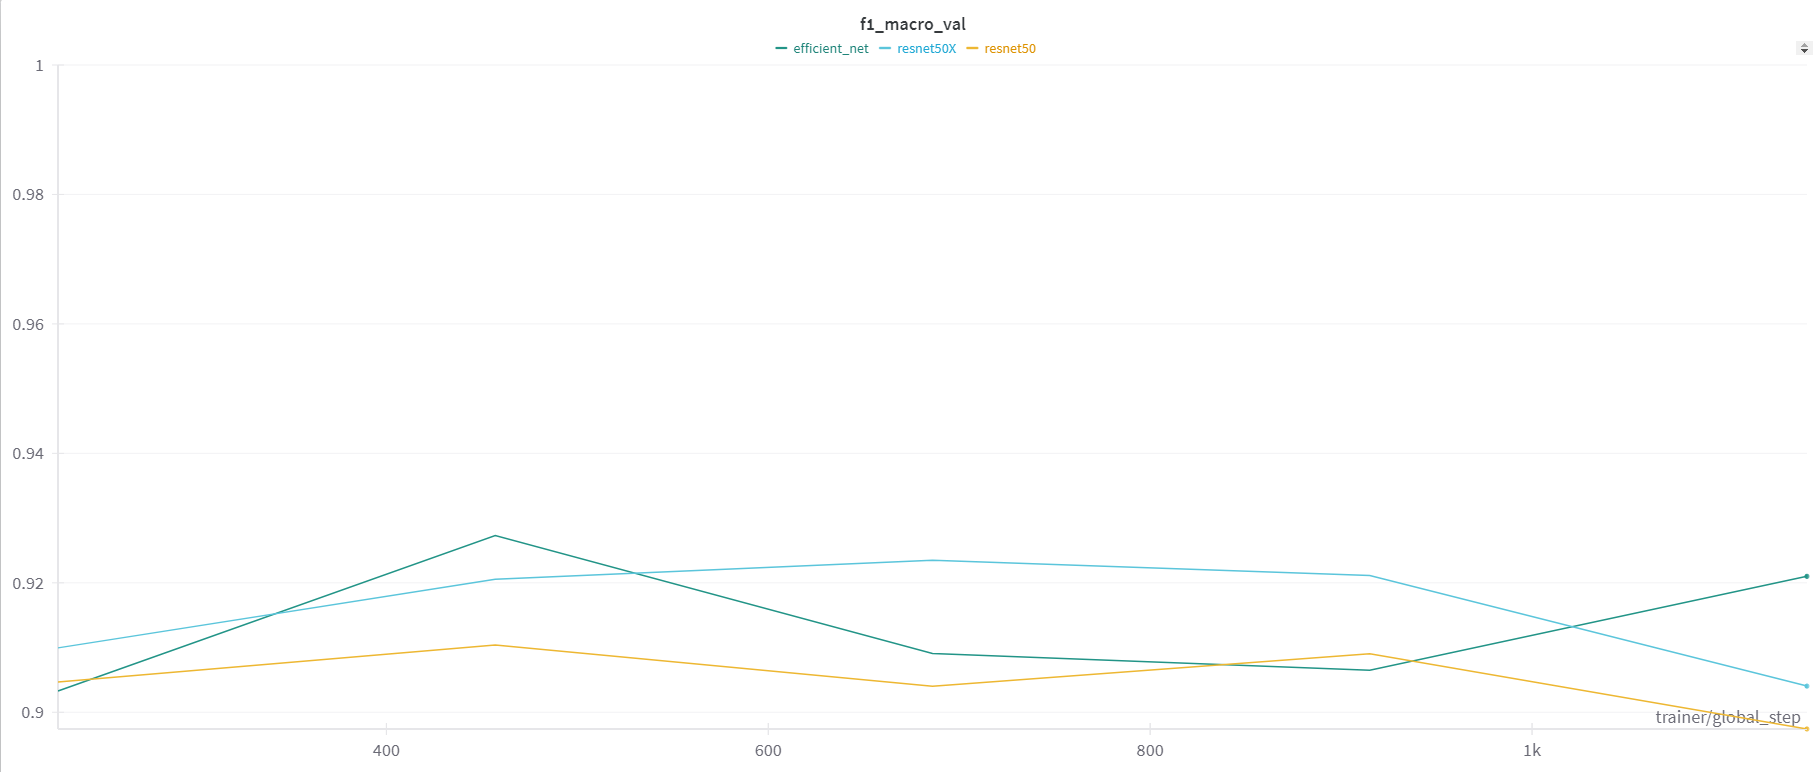

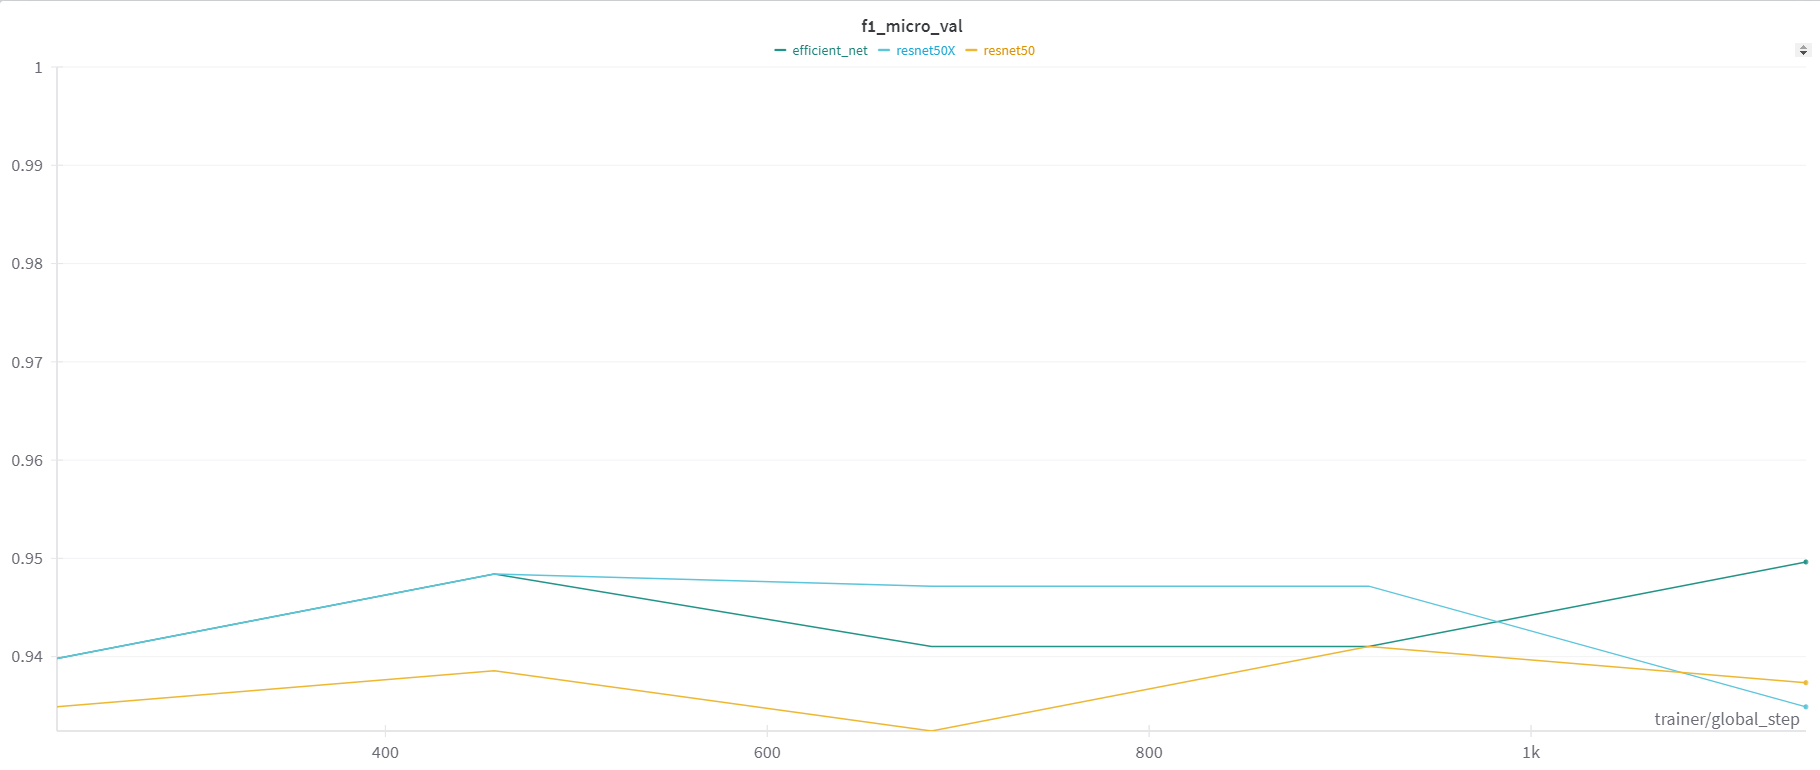

После я решил попробовать добавить дополнительную аугментацию к EfficientNet и проверить как это влияет на качество модели

In [ ]:
# Аугментация
train_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomCrop(height=128, width=128),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

test_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.CenterCrop(height=128, width=128),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

train_ds = MarketDataset(image_file_list, transform=train_transform, class_dict = class_dict, train='train')
test_ds = MarketDataset(image_file_list, transform=test_transform, class_dict = class_dict, train='test')
val_ds = MarketDataset(image_file_list, transform=test_transform, class_dict = class_dict, train='val')

In [ ]:
train_dataloader = DataLoader(train_ds, batch_size = batch_s, sampler=train_sampler)
test_dataloader = DataLoader(test_ds, batch_size = batch_s)
val_dataloader = DataLoader(val_ds, batch_size = batch_s)

In [ ]:
module = LightningModule(efficientnet_model, learning_rate=5e-5).to(device)

wandb_logger = WandbLogger(name = 'efficient_net_albumentation', project="MarketData")

trainer = pl.Trainer(max_epochs = 10,
                    accelerator = 'gpu',
                    logger = wandb_logger,
                    callbacks=[checkpoint_callback])
trainer.fit(module, train_dataloader, test_dataloader)

wandb.finish()

In [ ]:
model_dict = {'efficient_net_albumentation': efficientnet_model}

for model in model_dict:
    cur_model = model_dict[model]
    predictions = predict(cur_model.to(device), val_dataloader)
    preds = nn.functional.softmax(torch.cat(predictions), dim=-1).argmax(-1).cpu().numpy()
    p = []
    for _, label in val_dataloader:
      p.extend(label.numpy())

    model_res_dict[model] = [metrics.f1_score(p, preds, average = 'macro'),
    metrics.f1_score(p, preds, average = 'micro'),
    metrics.accuracy_score(p, preds)]

In [ ]:
pd.DataFrame(model_res_dict).T.rename(columns = {0: 'f1_macro', 1: 'f1_micro', 2: 'accuracy'})

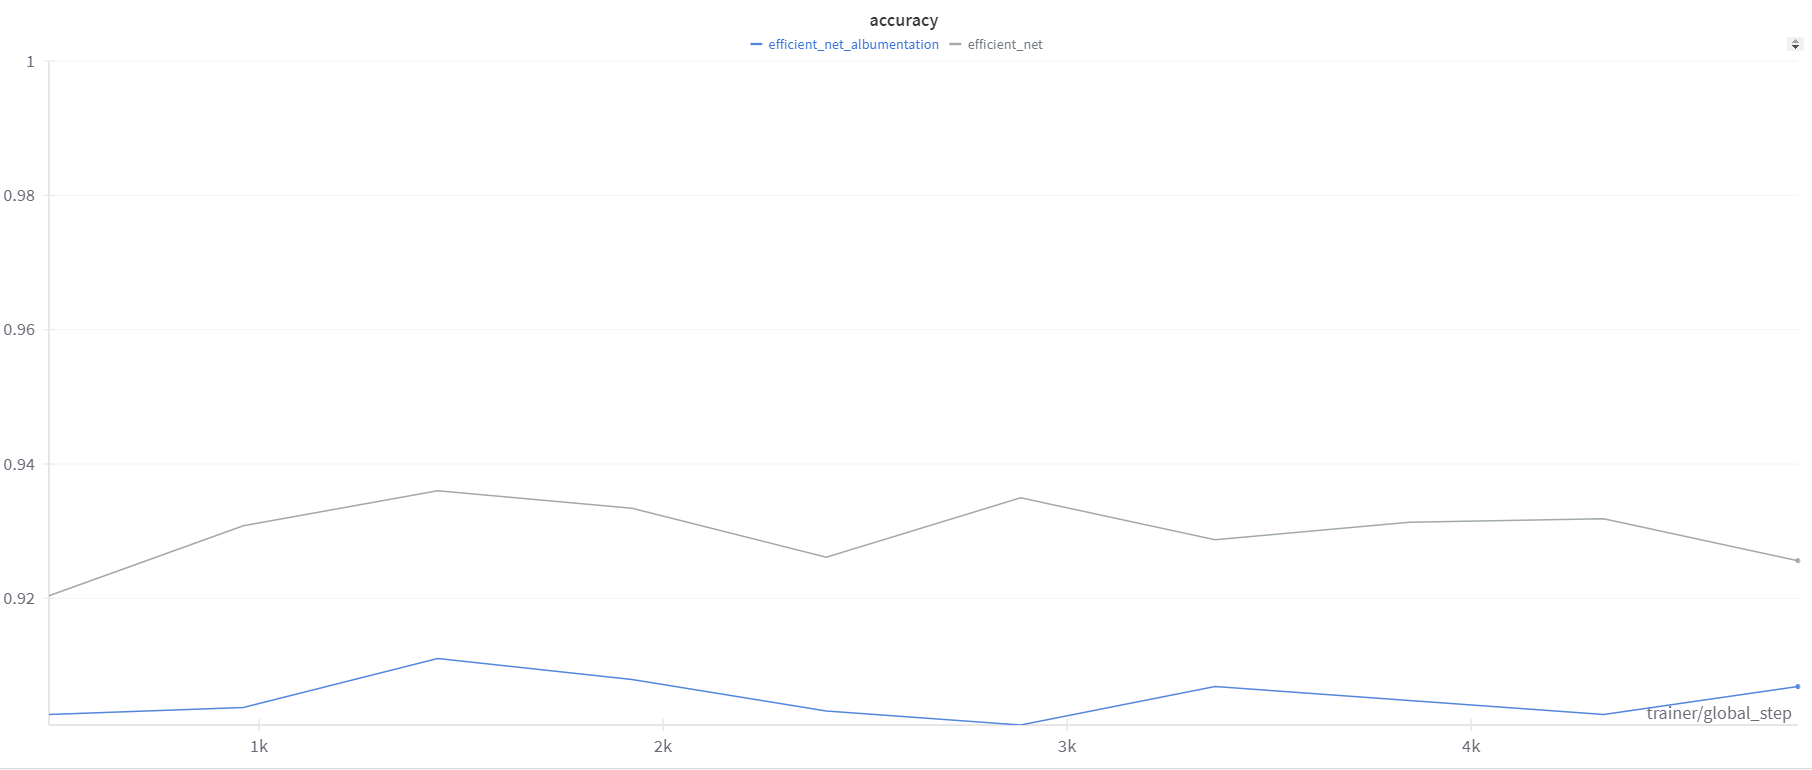
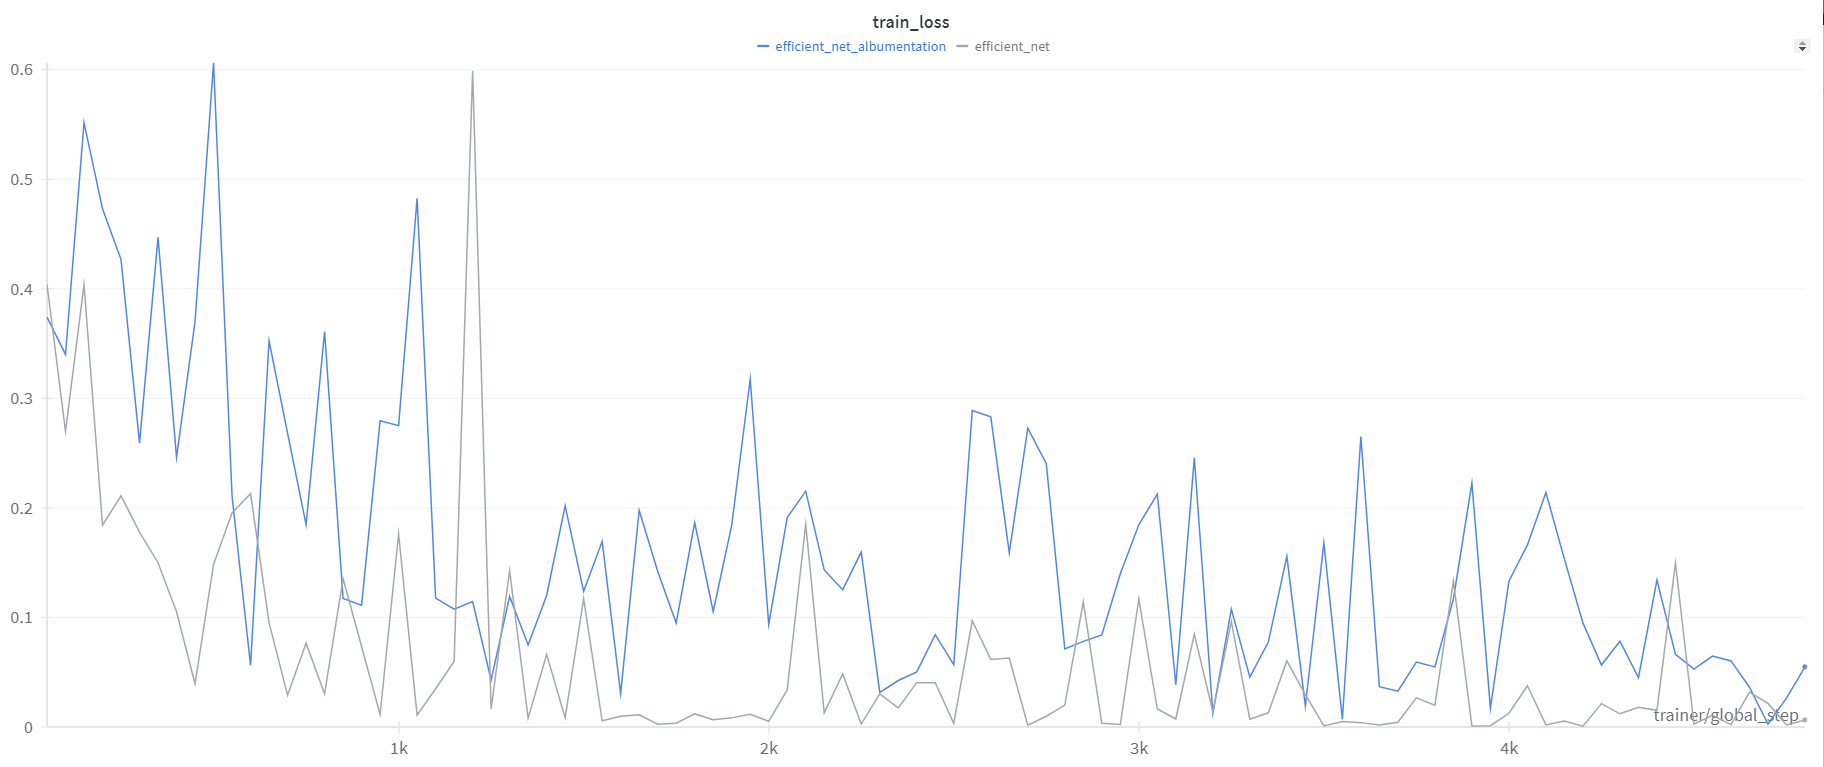

Модель с аугментацией значительно хуже по качеству

# HuggingFace

## Классификация изображений

Я также попробовал применить претренированные модели vit16 и resnet152 из HuggingFace

In [ ]:
import evaluate
from datasets import load_dataset, DatasetDict
import numpy as np
from transformers import AutoImageProcessor

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis = -1)
    return accuracy.compute(predictions=predictions, references=labels)

ds = load_dataset("/content/Marketdata")
train_testvalid = ds['train'].train_test_split(test_size=0.2)
test_valid = train_testvalid['test'].train_test_split(test_size=0.5)

ds = DatasetDict({
    'train': train_testvalid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']})

Resolving data files:   0%|          | 0/19218 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

checkpoint = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

ds = ds.with_transform(transforms)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

In [ ]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(class_dict),
    id2label=inv_class_dict,
    label2id=class_dict,
    ignore_mismatched_sizes=True
)

pytorch_model.bin:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
os.mkdir('res')

In [ ]:
training_args = TrainingArguments(
    output_dir="res",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds['train'],
    eval_dataset=ds['test'],
    compute_metrics=compute_metrics,
)

trainer.train()

In [ ]:
checkpoint = 'microsoft/resnet-152'
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

ds = ds.with_transform(transforms)

model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(class_dict),
    id2label=inv_class_dict,
    label2id=class_dict,
    ignore_mismatched_sizes=True
)

training_args = TrainingArguments(
    output_dir="res",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    # gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    # push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    # data_collator=data_collator,
    train_dataset=ds['train'],
    eval_dataset=ds['test'],
    # tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

trainer.train()

##Текстовые модели

###Подготовка текстовых данных

В качестве текстовых данных выступают текста объявлений, я убрал из них лишние символы и стеммизировал слова. Затем я использовал токенайзер из модели rubert-tiny2 для токенизации очищенного текста. Несмотря на то, что модель изначально была зафайнтюнена для оценки сентимента её токенайзер хорошо подходит для анализа текстов объявлений, а расширение количества меток классификатора и дообучение показали хорошие результаты >0.94 accuracy на тестовой выборке.

In [ ]:
df_list = []
for file in csv_file_list:
    cur_df = pd.read_csv(file)
    cur_df['label'] = file.stem
    df_list.append(cur_df)

df = pd.concat(df_list)

df.drop(columns = 'Unnamed: 0', inplace = True)

def clean_text(text):
    text=text.lower()
    text=re.sub(r'[^а-яa-z0-9 ]', '', text)
    stop_words=set(stopwords.words("russian"))

    text = re.sub(r'\d+', '', text)
    text = text.split()
    text=(word for word in text if word not in stop_words)

    stemmer = SnowballStemmer("russian")
    lemmatized_words=[stemmer.stem(word) for word in text]

    clean_words=" ".join(lemmatized_words)

    return clean_words

df["lemmatize_text"]=df['desc'].apply(clean_text)
tokenizer = BertTokenizer.from_pretrained('cointegrated/rubert-tiny2')

file_dict = {int(file.stem): file for file in image_file_list}
df['img_file_path'] = df['ads_id'].map(file_dict)
df.reset_index(drop = True, inplace = True)
df.drop_duplicates('ads_id', inplace = True)
df.reset_index(drop = True, inplace = True)
df['img_file_path'].fillna('-', inplace = True)
df.head()

In [ ]:
from datasets import Dataset, DatasetDict
from transformers import BertForSequenceClassification
from transformers import DataCollatorWithPadding
from transformers import AutoTokenizer
import evaluate
import numpy as np

df['label_id'] = df['label'].map(class_dict)
dataset = Dataset.from_pandas(df[['lemmatize_text', 'label_id']].rename(columns = {'label_id':
                                                     'label',
                                            'lemmatize_text': 'text'}))
train_testvalid = dataset.train_test_split(test_size=0.2)
test_valid = train_testvalid['test'].train_test_split(test_size=0.5)
ds = DatasetDict({
    'train': train_testvalid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']})

tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_ds = ds.map(preprocess_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(
    "cointegrated/rubert-tiny2", num_labels=len(class_dict), id2label=inv_class_dict,
    label2id=class_dict
)

training_args = TrainingArguments(
    output_dir="my_awesome_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=7,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    # push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

# Объединение моделей

## Подготовка данных
Далее я решил объединить предсказания текстовых и cv моделей. Для этого я создал датасет возвращающий 4 значения: изображение, input_ids, маску внимания и цену указанную в объявлении.

In [ ]:
class MarketFullDataset(Dataset):
    def __init__(self, df, transform, class_dict, tokenizer):
        self.transform = transform
        self.class_dict = class_dict
        self.tokenizer = tokenizer
        self.df = df

        self.input_ids, self.attention_mask = self.create_text(df['desc'])

    def __len__(self):
          return len(self.df)

    def __getitem__(self, idx):
        cur_df = self.df.iloc[idx].to_dict()
        fname = cur_df['img_file_path']
        if fname != '-':
          image = np.array(Image.open(fname).convert('RGB'))
          image = self.transform(image = image)['image'].to(device)
        else:
          image = torch.zeros([3, 232, 232]).to(device)

        label = cur_df['label']
        label = self.class_dict[label]

        price = cur_df['price']

        return {'image': image,
                'input_ids': self.input_ids[idx, :1000],
                'attention_mask': self.attention_mask[idx, :1000],
                'price': price}, label

    def create_text(self, text):
        # Токенизация всего текста
        tokenized = self.tokenizer(text.tolist(),
                                   padding=True,
                                   truncation=True,
                                   return_tensors="pt").to(device)

        return tokenized['input_ids'], tokenized['attention_mask']

    def get_all_labels(self):
        return self.df['label'].values

mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = A.Compose(
    [
        A.Resize(232, 232),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ]
)

test_transform = A.Compose(
    [
        A.Resize(232, 232),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ]
)

class_dict = {name: label for label, name in enumerate(df.label.unique())}
inv_class_dict = {v: k for k, v in class_dict.items()}

from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size = 0.2, random_state = 42)
test_df, valid_df = train_test_split(df, test_size = 0.5, random_state = 42)
train_df['label'].value_counts()

In [ ]:
train_ds_full = MarketFullDataset(df = train_df, transform=train_transform, class_dict = class_dict,
                                 tokenizer = tokenizer)
test_ds_full = MarketFullDataset(df = test_df, transform=train_transform, class_dict = class_dict,
                                 tokenizer = tokenizer)
valid_ds_full = MarketFullDataset(df = valid_df, transform=train_transform, class_dict = class_dict,
                                 tokenizer = tokenizer)

# Подсчет весов для классов
cnt = Counter(train_ds_full.get_all_labels())
sample_weights = np.array([cnt[i] for i in train_ds_full.get_all_labels()])
batch_s = 8

train_sampler = WeightedRandomSampler(sample_weights, num_samples=len(train_ds_full), replacement=True)

batch_size = 8
train_dataloader = torch.utils.data.DataLoader(train_ds_full, batch_size=batch_size, sampler=train_sampler)
test_dataloader = torch.utils.data.DataLoader(test_ds_full, batch_size=batch_size, shuffle = True)
valid_dataloader = torch.utils.data.DataLoader(valid_ds_full, batch_size=batch_size)

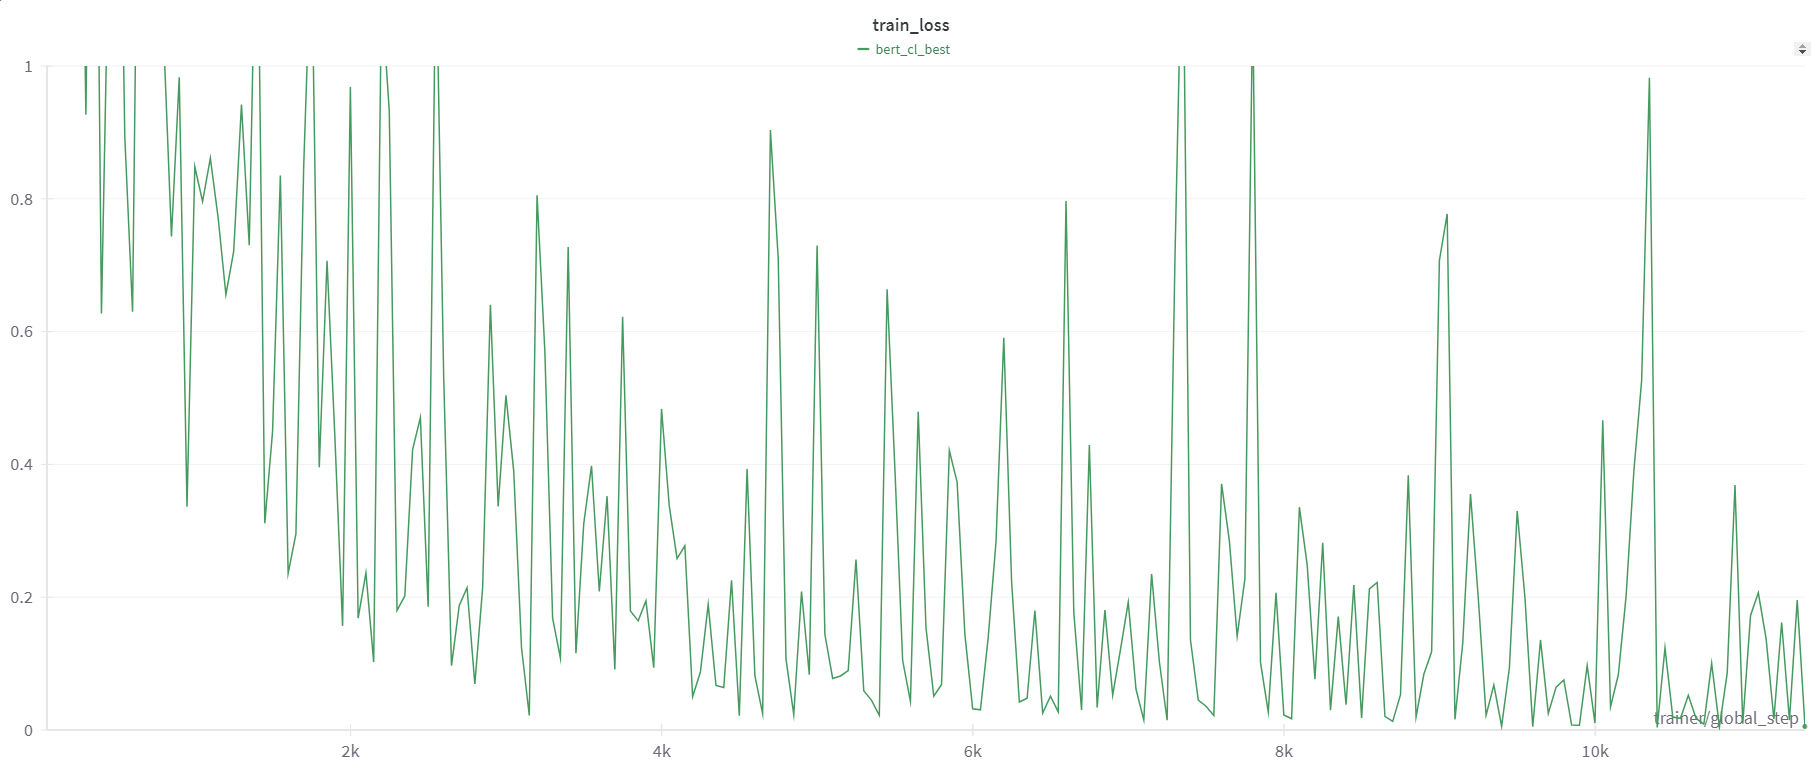

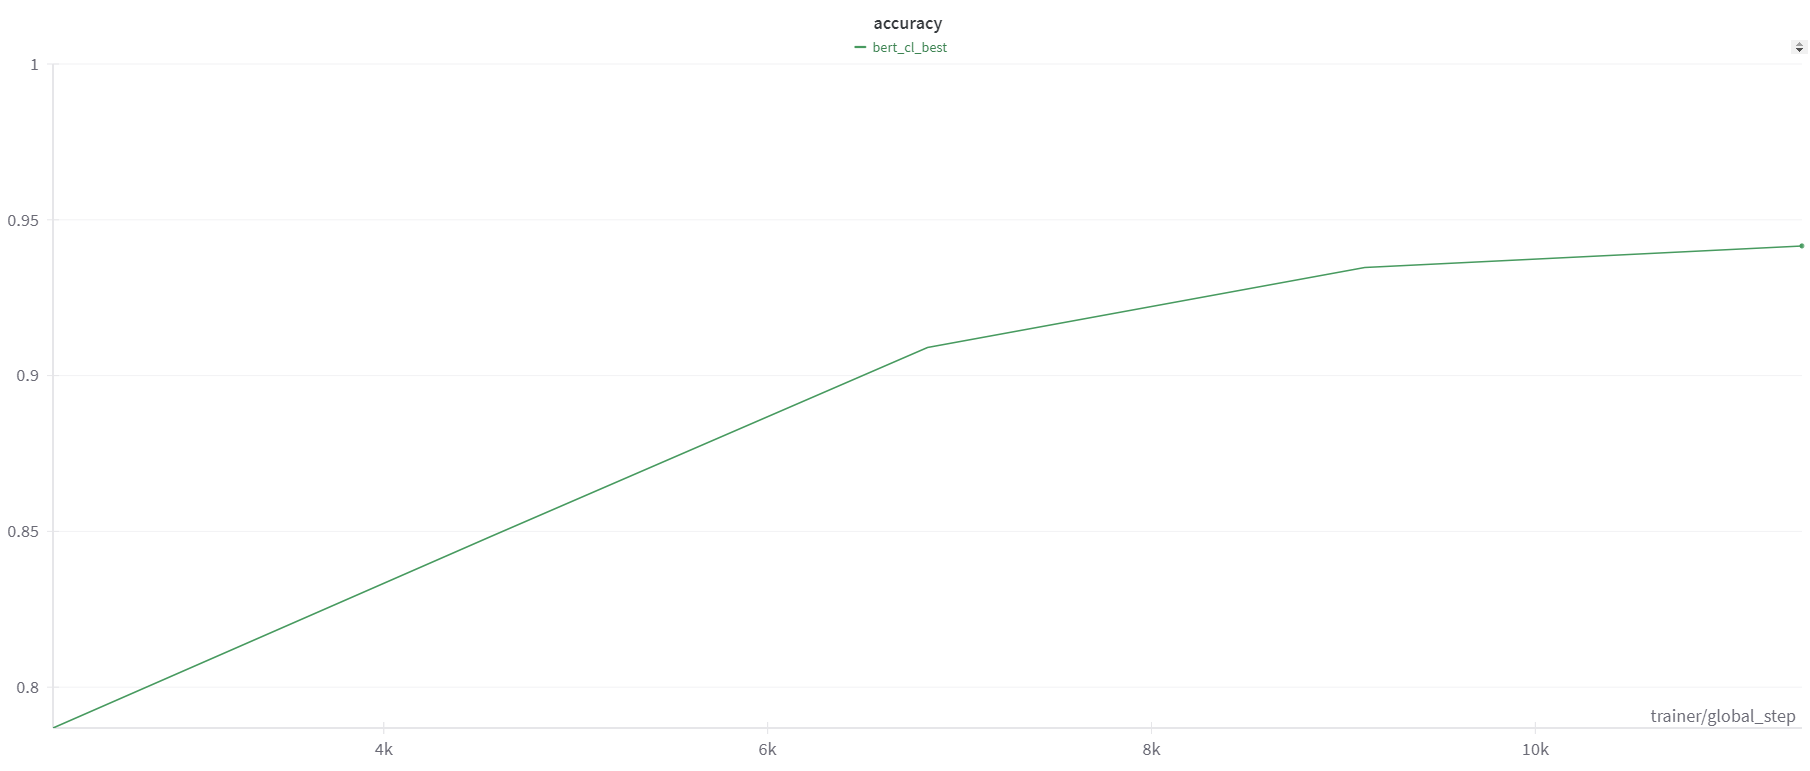

## Объединенная нейросеть
Я попробовал несколько способов реализации объединенной нейросети, вот один из них:
я использовал извлечение признаков из двух предобученных моделей, а затем добавил несколько сверточных слоев и линейные слои для классификации в конце.

In [ ]:
from transformers import BertForSequenceClassification
import torch.optim as optim
from torch.nn.parallel import DataParallel


class MergedCNN(nn.Module):

    def __init__(self, n_classes, batch_size):
        super().__init__()
        self.n_classes = n_classes
        self.batch_size = batch_size

        rubert = BertForSequenceClassification.from_pretrained('cointegrated/rubert-tiny2',
                                              num_labels = n_classes,
                                              ignore_mismatched_sizes=True)
        rubert.load_state_dict(torch.load('/content/bert9315.pth'))
        for param in rubert.parameters():
            param.requires_grad = False

        efficientnet_model = models.efficientnet_v2_s(pretrained=True)
        num_features = efficientnet_model.classifier[1].in_features
        efficientnet_model.classifier[1] = nn.Linear(num_features, n_classes)
        efficientnet_model = efficientnet_model.to(device)
        efficientnet_model.load_state_dict(torch.load('/content/effnet0939.pt'))

        for param in efficientnet_model.parameters():
            param.requires_grad = False

        self.rubert = rubert.to(device)
        self.effnet = efficientnet_model.to(device)

        self.con1 = nn.Conv1d(1, 32, 2)
        self.con2 = nn.Conv1d(32, 16, 2)
        self.con3 = nn.Conv1d(16, 8, 2)
        self.con4 = nn.Conv1d(8, 4, 2)
        self.con5 = nn.Conv1d(4, 2, 2)
        self.con6 = nn.Conv1d(2, 1, 2)

        self.linear1 = nn.Linear(in_features = 1280 + 312 + 1 - 6, out_features = 1024)
        self.linear1 = nn.Linear(in_features = 1280 + 312 + 1 - 4, out_features = 1024)
        self.linear2 = nn.Linear(in_features = 1024, out_features = 256)
        self.linear3 = nn.Linear(in_features = 256, out_features = 32)
        self.linear4 = nn.Linear(in_features = 32, out_features = n_classes)

        self.relu = nn.ReLU()

    def forward(self, x):
        img = self.effnet.features(x['image'])
        img = self.effnet.avgpool(img).squeeze()

        text = self.rubert.bert(x['input_ids'], attention_mask = x['attention_mask'])['pooler_output']

        batch_size = text.size()[0]

        price = torch.tensor(x['price'], device = device).reshape(batch_size, -1)

        x = torch.cat([img, text, price], dim = 1)

        x = x.reshape(batch_size, 1, -1)

        x = self.con1(x)
        x = self.con2(x)
        x = self.con3(x)
        x = self.con4(x)
        x = self.con5(x)
        x = self.con6(x)

        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = self.relu(x)
        x = self.linear4(x)
        x = self.relu(x)

        return x.squeeze()

In [ ]:
!cp '/content/drive/MyDrive/Market/effnet0939.pt' '/content/'
!cp '/content/drive/MyDrive/Market/bert9315.pth' '/content/'

In [ ]:
model = MergedCNN(len(class_dict), batch_size).to(device)

module = LightningModule(model, learning_rate=1e-5).to(device)

wandb_logger = WandbLogger(name = 'bert_effnet_conv', project="MarketData")

trainer = pl.Trainer(max_epochs = 5,
                    accelerator = 'gpu',
                    logger = wandb_logger)
trainer.fit(module, train_dataloader, test_dataloader)

wandb.finish()

Все виды объединенной нейросети показали очень низкий результат 0.6< accuracy, я решил, что, возможно, модели из классического обучения справятся лучше

##Объединение с помощью классических моделей

###Объединение фичей
Для обучения классических моделей я создал датафреймы из предсказанных фичей из предобученных моделей

In [ ]:
rubert = BertForSequenceClassification.from_pretrained('cointegrated/rubert-tiny2',
                                      num_labels = len(class_dict),
                                      ignore_mismatched_sizes=True)
rubert.load_state_dict(torch.load('/content/bert9315.pth'))
for param in rubert.parameters():
    param.requires_grad = False

effnet = models.efficientnet_v2_s(pretrained=True)
num_features = effnet.classifier[1].in_features
effnet.classifier[1] = nn.Linear(num_features, len(class_dict))
effnet = effnet.to(device)
effnet.load_state_dict(torch.load('/content/effnet0939.pt'))

rubert = rubert.to(device)
effnet = effnet.to(device)
for param in effnet.parameters():
    param.requires_grad = False

for param in rubert.parameters():
    param.requires_grad = False

features_df = []
for x, y in tqdm(test_dataloader):
    img = effnet.features(x['image'])
    img = effnet.avgpool(img).reshape(batch_size, -1)
    batch_size = img.size()[0]

    text = rubert.bert(x['input_ids'], attention_mask = x['attention_mask'])['pooler_output'].reshape(batch_size, -1)

    x = torch.cat([img, text], dim = 1)

    x = x
    y = y.reshape(-1, 1).to(device)
    x = torch.cat([x, y], dim = 1)
    features_df.append(x)

features_list = []
for i in features_df:
    features_list.extend(i.tolist())

features_df_valid = []
for x, y in tqdm(valid_dataloader):
    img = effnet.features(x['image'])
    img = effnet.avgpool(img).reshape(batch_size, -1)
    batch_size = img.size()[0]

    text = rubert.bert(x['input_ids'], attention_mask = x['attention_mask'])['pooler_output'].reshape(batch_size, -1)

    x = torch.cat([img, text], dim = 1)

    x = x
    y = y.reshape(-1, 1).to(device)
    x = torch.cat([x, y], dim = 1)
    features_df_valid.append(x)

valid_features_list = []
for i in features_df_valid:
    valid_features_list.extend(i.tolist())

df = pd.DataFrame(features_list)
y = df.iloc[:, -1]
X = df.iloc[:, :-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

###Обучение и предсказание моделей

В качестве моделей я использовал рандомный лес, knn и логистическую регрессию. Рандомный лес показал себя также плохо, как и нейросеть, в то же время knn и логистическая регресия позволили повысить качество предсказаний до почти идеального (> 0.99 по всем метрикам у логистической регрессии)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
res_list = {'RandomForestClassifier_train': {'macro f1': metrics.f1_score(y_test, preds, average = 'macro'),
'micro f1': metrics.f1_score(y_test, preds, average = 'micro'),
'f1': metrics.accuracy_score(y_test, preds)}}

from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=10)
neigh.fit(X_train, y_train)
preds = neigh.predict(X_test)
res_list['KNN_train'] = {'macro f1': metrics.f1_score(y_test, preds, average = 'macro'),
'micro f1': metrics.f1_score(y_test, preds, average = 'micro'),
'f1': metrics.accuracy_score(y_test, preds)}

from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
print(clf.score(X_train, y_train))

preds = clf.predict(X_test)
res_list['LogReg_train'] = {'macro f1': metrics.f1_score(y_test, preds, average = 'macro'),
'micro f1': metrics.f1_score(y_test, preds, average = 'micro'),
'f1': metrics.accuracy_score(y_test, preds)}

from sklearn.model_selection import GridSearchCV
param_grid = dict(n_neighbors=[2, 5, 10, 15, 20, 50, 100])
grid = GridSearchCV(neigh, param_grid, cv=10, scoring='accuracy', return_train_score=False)
grid.fit(X_train, y_train)

preds = grid.best_estimator_.predict(X_test)
res_list['Best_KNN_test'] = {'macro f1': metrics.f1_score(y_test, preds, average = 'macro'),
'micro f1': metrics.f1_score(y_test, preds, average = 'micro'),
'f1': metrics.accuracy_score(y_test, preds)}

preds = clf.predict(X)
res_list['LogReg_test'] = {'macro f1': metrics.f1_score(y, preds, average = 'macro'),
'micro f1': metrics.f1_score(y, preds, average = 'micro'),
'f1': metrics.accuracy_score(y, preds)}

In [ ]:
pd.DataFrame(res_list).T

,macro f1,micro f1,f1
RandomForestClassifier_train,0.375960,0.651032,0.651032
KNN_train,0.954844,0.967167,0.967167
LogReg_train,0.956949,0.968105,0.968105
Best_KNN_test,0.954844,0.967167,0.967167
LogReg_test,0.991412,0.993619,0.993619
